# COMPAS ANALYSIS

In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [215]:
# Charger les données
df = pd.read_csv("./compas-scores-two-years.csv")

In [216]:
# Appliquer les filtres
df = (
    df[
        (df["days_b_screening_arrest"] <= 30) &  # Filtrer les arrestations dans les 30 jours
        (df["days_b_screening_arrest"] >= -30) &
        (df["is_recid"] != -1) &                # Exclure les valeurs -1 pour is_recid
        (df["c_charge_degree"] != "O") &        # Exclure les charges de type "O"
        (df["score_text"] != "N/A") &           # Exclure les scores non disponibles
        (df["race"].isin(["African-American", "Caucasian"])) # Garder seulement les Noirs et Blancs
    ]
)

In [217]:
# Afficher la taille finale des données
print(f"Nombre de lignes après filtrage : {len(df)}")

Nombre de lignes après filtrage : 5278


In [163]:
# Créer des sous-données pour chaque groupe racial
black_defendants = df[df["race"] == "African-American"]
white_defendants = df[df["race"] == "Caucasian"]

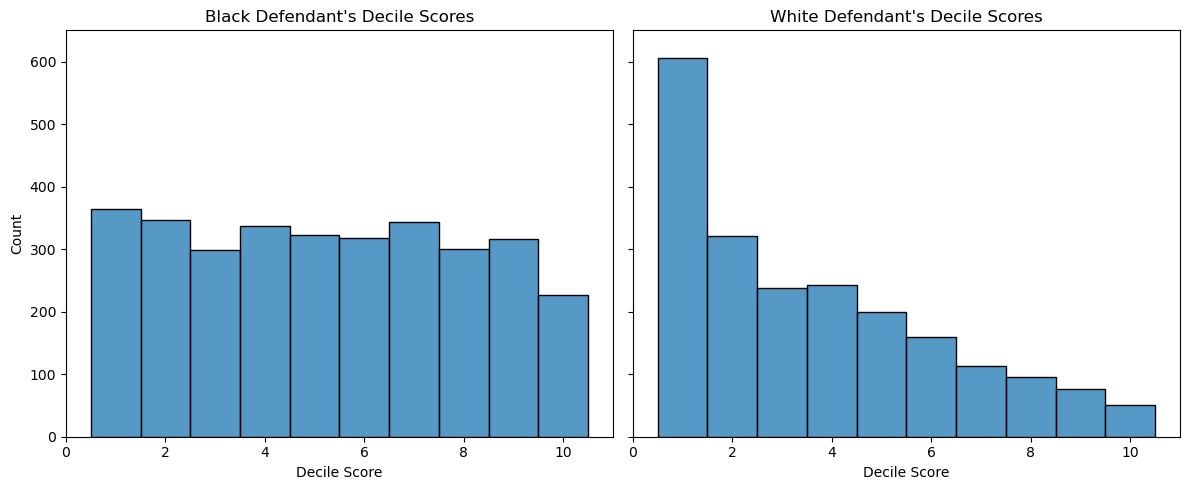

In [164]:
# Initialiser la figure pour deux graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
# Créer l'histogramme pour les scores déciles des prévenus noirs
sns.histplot(
    black_defendants["decile_score"],
    bins=10,
    discrete=True,
    ax=axes[0],
    kde=False
)
axes[0].set_title("Black Defendant's Decile Scores")
axes[0].set_xlabel("Decile Score")
axes[0].set_ylabel("Count")
axes[0].set_ylim(0, 650)

# Créer l'histogramme pour les scores déciles des prévenus blancs
sns.histplot(
    white_defendants["decile_score"],
    bins=10,
    discrete=True,
    ax=axes[1],
    kde=False
)
axes[1].set_title("White Defendant's Decile Scores")
axes[1].set_xlabel("Decile Score")
axes[1].set_ylim(0, 650)

# Afficher les graphiques
plt.tight_layout()
plt.show()

In [200]:
# Charger les données
df2 = pd.read_csv("./compas-scores-two-years-violent.csv")

In [201]:
df2 = (
    df2[
        (df2["days_b_screening_arrest"] <= 30) &  # Filtrer les arrestations dans les 30 jours
        (df2["days_b_screening_arrest"] >= -30) &
        (df2["is_violent_recid"] != -1) &                # Exclure les valeurs -1 pour is_recid
        (df2["vr_charge_degree"] != "O") &        # Exclure les charges de type "O"
        (df2["v_score_text"] != "N/A") &           # Exclure les scores non disponibles
        (df2["race"].isin(["African-American", "Caucasian"])) # Garder seulement les Noirs et Blancs
    ]
)

In [202]:
# Afficher la taille finale des données
print(f"Nombre de lignes après filtrage : {len(df2)}")

Nombre de lignes après filtrage : 3377


In [171]:
# Créer des sous-données pour chaque groupe racial
black_defendants2 = df2[df2["race"] == "African-American"]
white_defendants2 = df2[df2["race"] == "Caucasian"]

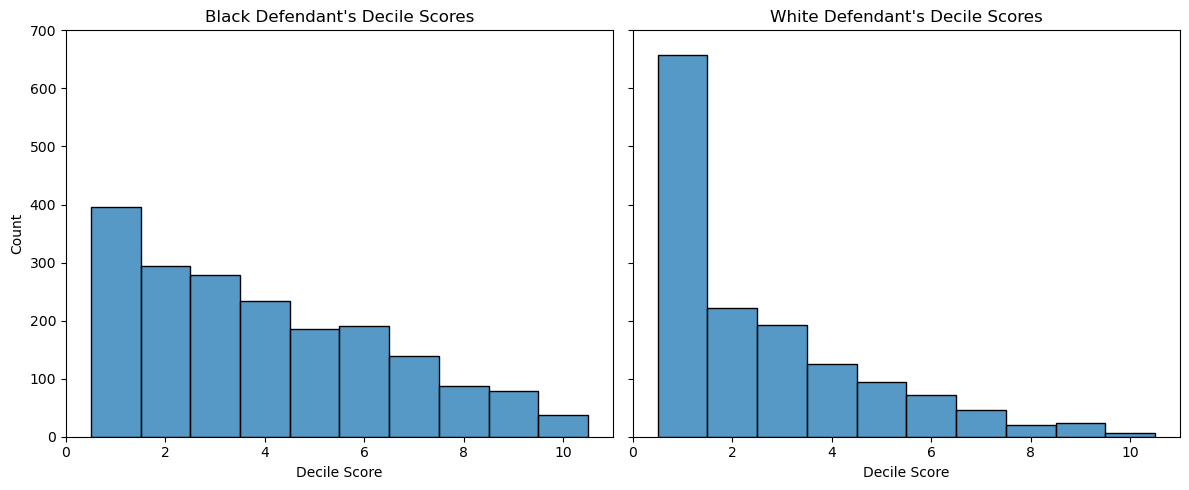

In [172]:
# Initialiser la figure pour deux graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
# Créer l'histogramme pour les scores déciles des prévenus noirs
sns.histplot(
    black_defendants2["v_decile_score"],
    bins=10,
    discrete=True,
    ax=axes[0],
    kde=False
)
axes[0].set_title("Black Defendant's Decile Scores")
axes[0].set_xlabel("Decile Score")
axes[0].set_ylabel("Count")
axes[0].set_ylim(0, 700)

# Créer l'histogramme pour les scores déciles des prévenus blancs
sns.histplot(
    white_defendants2["v_decile_score"],
    bins=10,
    discrete=True,
    ax=axes[1],
    kde=False
)
axes[1].set_title("White Defendant's Decile Scores")
axes[1].set_xlabel("Decile Score")
axes[1].set_ylim(0, 700)

# Afficher les graphiques
plt.tight_layout()
plt.show()

# Tester les biais dans les prédictions :

### 1) AUC-ROC : Calculez les courbes ROC et comparez les performances entre les groupes raciaux. 
* Récidive Générale

In [182]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

# Fonction pour calculer l'AUC pour un groupe racial donné
def calculate_auc(df, outcome, score):
    y_true = df[outcome]
    y_scores = df[score]
    auc = roc_auc_score(y_true, y_scores)
    return auc


# AUC pour les récidives générales
auc_black = calculate_auc(black_defendants, "is_recid", "decile_score")
auc_white = calculate_auc(white_defendants, "is_recid", "decile_score")

print(f"AUC for Black defendants: {auc_black}")
print(f"AUC for White defendants: {auc_white}")

# Calculer l'AUC-ROC pour l'ensemble des données
y_true = df["is_recid"]  # Variable cible
y_scores = df["decile_score"]  # Score décile

auc_roc_all = roc_auc_score(y_true, y_scores)
print(f"AUC-ROC globale pour la récidive générale : {auc_roc_all:.3f}")


AUC for Black defendants: 0.7018904988683478
AUC for White defendants: 0.6914967797673686
AUC-ROC globale pour la récidive générale : 0.711


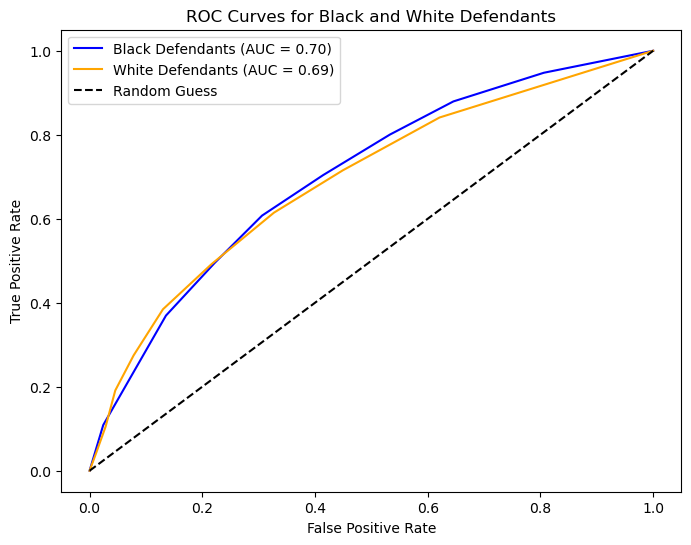

In [183]:
# Tracer les courbes ROC
fpr_black, tpr_black, _ = roc_curve(black_defendants["is_recid"], black_defendants["decile_score"])
fpr_white, tpr_white, _ = roc_curve(white_defendants["is_recid"], white_defendants["decile_score"])

plt.figure(figsize=(8, 6))
plt.plot(fpr_black, tpr_black, label=f'Black Defendants (AUC = {auc_black:.2f})', color='blue')
plt.plot(fpr_white, tpr_white, label=f'White Defendants (AUC = {auc_white:.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Black and White Defendants')
plt.legend()
plt.show()

### 2) Z-tests : Comparez les AUC entre noirs et blancs pour détecter des différences significatives.

In [184]:
import numpy as np

# Taille des échantillons
n_black = len(black_defendants)
n_white = len(white_defendants)

# Formule du test Z
z = (auc_black - auc_white) / np.sqrt((auc_black * (1 - auc_black) / n_black) + (auc_white * (1 - auc_white) / n_white))
print(f"Z-score: {z}")

Z-score: 0.8034660414784438


### 1)AUC-ROC : Calculez les courbes ROC et comparez les performances entre les groupes raciaux.¶
* Récidive Violente

In [185]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np

# Calculer l'AUC-ROC pour l'ensemble des données
y_true = df2["is_violent_recid"]  # Variable cible
y_scores = df2["v_decile_score"]  # Score décile

auc_roc_all = roc_auc_score(y_true, y_scores)
print(f"AUC-ROC globale pour la récidive violente : {auc_roc_all:.3f}")

# Calculer l'AUC-ROC pour chaque groupe racial
for race in ["African-American", "Caucasian"]:
    subset = df2[df2["race"] == race]
    auc_roc_race = roc_auc_score(subset["is_violent_recid"], subset["v_decile_score"])
    print(f"AUC-ROC pour {race} : {auc_roc_race:.3f}")

AUC-ROC globale pour la récidive violente : 0.714
AUC-ROC pour African-American : 0.707
AUC-ROC pour Caucasian : 0.683


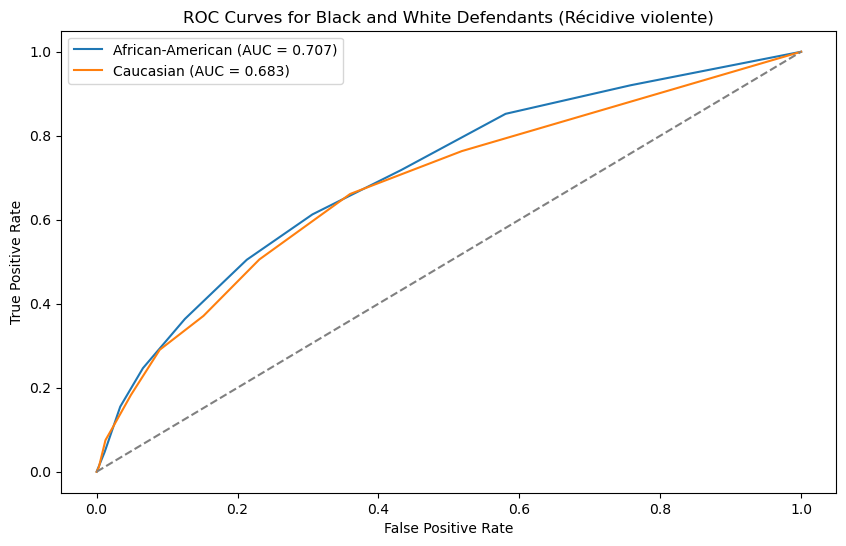

In [186]:
# Tracer les courbes ROC pour chaque groupe racial
plt.figure(figsize=(10, 6))

for race in ["African-American", "Caucasian"]:
    subset = df2[df2["race"] == race]
    fpr, tpr, _ = roc_curve(subset["is_violent_recid"], subset["v_decile_score"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{race} (AUC = {roc_auc:.3f})")

# Tracer la ligne aléatoire
plt.plot([0, 1], [0, 1], color="grey", linestyle="--")

# Paramètres du graphique
plt.title("ROC Curves for Black and White Defendants (Récidive violente)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### 2) Z-tests : Comparez les AUC entre noirs et blancs pour détecter des différences significatives.

In [188]:
import numpy as np

# Taille des échantillons
n_black = len(black_defendants2)
n_white = len(white_defendants2)

# Formule du test Z
z = (auc_black - auc_white) / np.sqrt((auc_black * (1 - auc_black) / n_black) + (auc_white * (1 - auc_white) / n_white))
print(f"Z-score: {z}")

Z-score: 0.6504861772170171


### Regression Logistic

* Recidive général

In [211]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [212]:
# Créer une variable binaire pour la race (1 = Black, 0 = White)
df["Black"] = (df["race"] == "African-American").astype(int)

# Préparer les données pour la régression
df["Female"] = (df["sex"] == "Female").astype(int)  # Binaire pour le sexe
df["NPC_Decile"] = df["decile_score"]  # Renommer le score décile
df["Age"] = df["age"]  # Garde la variable âge


# Model 1 : Variables démographiques (âge, sexe)
model1 = smf.logit("is_recid ~ Age + Female", data=df).fit()

# Model 2 : Ajouter le score COMPAS (NPC_Decile)
model2 = smf.logit("is_recid ~ Age + Female + NPC_Decile", data=df).fit()

# Model 3 : Ajouter la race
model3 = smf.logit("is_recid ~ Age + Female + NPC_Decile + Black", data=df).fit()

# Model 4 : Ajouter l'interaction entre race et score COMPAS
model4 = smf.logit("is_recid ~ Age + Female + NPC_Decile + Black + NPC_Decile:Black", data=df).fit()

# Résultats
print("\nModel 1 Summary:")
print(model1.summary())

print("\nModel 2 Summary:")
print(model2.summary())

print("\nModel 3 Summary:")
print(model3.summary())

print("\nModel 4 Summary:")
print(model4.summary())

Optimization terminated successfully.
         Current function value: 0.666950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615026
         Iterations 5

Model 1 Summary:
                           Logit Regression Results                           
Dep. Variable:               is_recid   No. Observations:                 5278
Model:                          Logit   Df Residuals:                     5275
Method:                           MLE   Df Model:                            2
Date:                Thu, 28 Nov 2024   Pseudo R-squ.:                 0.03536
Time:                        00:59:31   Log-Likelihood:                -3520.2
converged:                       True   LL-Null:                       -3649.2
Covariance Type:     

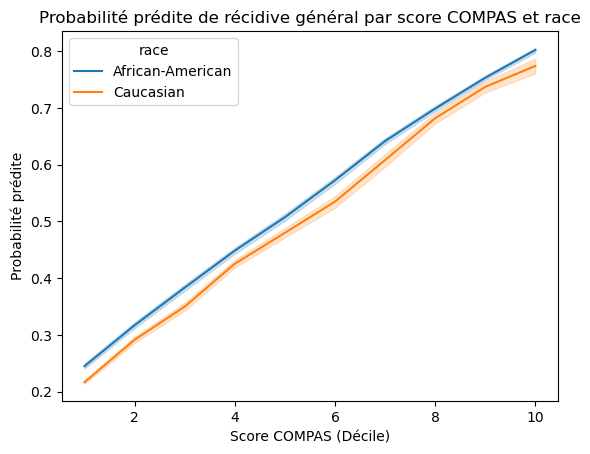

In [213]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Créer des probabilités prédites pour le modèle final
df["Predicted_Prob"] = model4.predict()

# Visualiser les probabilités prédites par score COMPAS et par race
sns.lineplot(data=df, x="NPC_Decile", y="Predicted_Prob", hue="race")
plt.title("Probabilité prédite de récidive général par score COMPAS et race")
plt.xlabel("Score COMPAS (Décile)")
plt.ylabel("Probabilité prédite")
plt.show()


* Récidive violent

In [206]:
# Créer une variable binaire pour la race (1 = Black, 0 = White)
df2["Black"] = (df2["race"] == "African-American").astype(int)

# Préparer les données pour la régression
df2["Female"] = (df2["sex"] == "Female").astype(int)  # Binaire pour le sexe
df2["NPC_Decile"] = df2["v_decile_score"]  # Renommer le score décile
df2["Age"] = df2["age"]  # Garde la variable âge


# Model 1 : Variables démographiques (âge, sexe)
model1 = smf.logit("is_violent_recid ~ Age + Female", data=df2).fit()

# Model 2 : Ajouter le score COMPAS (NPC_Decile)
model2 = smf.logit("is_violent_recid ~ Age + Female + NPC_Decile", data=df2).fit()

# Model 3 : Ajouter la race
model3 = smf.logit("is_violent_recid ~ Age + Female + NPC_Decile + Black", data=df2).fit()

# Model 4 : Ajouter l'interaction entre race et score COMPAS
model4 = smf.logit("is_violent_recid ~ Age + Female + NPC_Decile + Black + NPC_Decile:Black", data=df2).fit()

# Résultats
print("\nModel 1 Summary:")
print(model1.summary())

print("\nModel 2 Summary:")
print(model2.summary())

print("\nModel 3 Summary:")
print(model3.summary())

print("\nModel 4 Summary:")
print(model4.summary())

Optimization terminated successfully.
         Current function value: 0.453161
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424594
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423480
         Iterations 6

Model 1 Summary:
                           Logit Regression Results                           
Dep. Variable:       is_violent_recid   No. Observations:                 3377
Model:                          Logit   Df Residuals:                     3374
Method:                           MLE   Df Model:                            2
Date:                Thu, 28 Nov 2024   Pseudo R-squ.:                 0.04244
Time:                        00:52:29   Log-Likelihood:                -1530.3
converged:                       True   LL-Null:                       -1598.2
Covariance Type:     

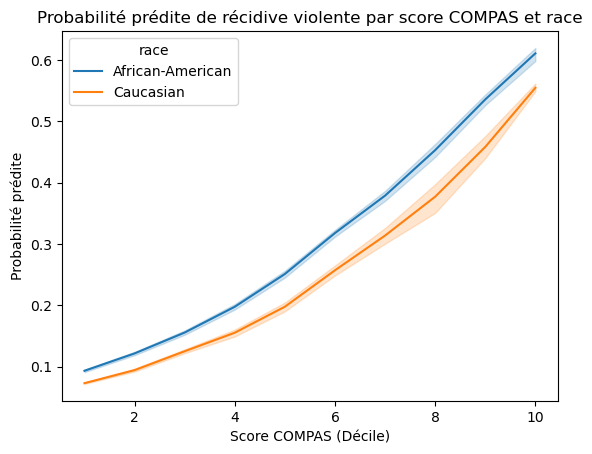

In [208]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Créer des probabilités prédites pour le modèle final
df2["Predicted_Prob"] = model4.predict()

# Visualiser les probabilités prédites par score COMPAS et par race
sns.lineplot(data=df2, x="NPC_Decile", y="Predicted_Prob", hue="race")
plt.title("Probabilité prédite de récidive violente par score COMPAS et race")
plt.xlabel("Score COMPAS (Décile)")
plt.ylabel("Probabilité prédite")
plt.show()

# faux positifs (FP) et faux négatifs (FN) par race

* Récidive général

In [218]:
# Fonction pour créer une matrice de confusion
def calculate_confusion_matrix(df, predicted_col, actual_col):
    TP = ((df[predicted_col] == 1) & (df[actual_col] == 1)).sum()  # Vrais positifs
    FP = ((df[predicted_col] == 1) & (df[actual_col] == 0)).sum()  # Faux positifs
    TN = ((df[predicted_col] == 0) & (df[actual_col] == 0)).sum()  # Vrais négatifs
    FN = ((df[predicted_col] == 0) & (df[actual_col] == 1)).sum()  # Faux négatifs

    # Sensibilité, spécificité, etc.
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0
    false_negative_rate = FN / (FN + TP) if (FN + TP) > 0 else 0
    positive_predictive_value = TP / (TP + FP) if (TP + FP) > 0 else 0
    negative_predictive_value = TN / (TN + FN) if (TN + FN) > 0 else 0

    return {
        "TP": TP, "FP": FP, "TN": TN, "FN": FN,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "FP Rate": false_positive_rate,
        "FN Rate": false_negative_rate,
        "PPV": positive_predictive_value,
        "NPV": negative_predictive_value
    }

# Préparer les colonnes de prédiction pour les deux regroupements
# Low vs Moderate/High
df["predicted_low_vs_mod_high"] = df["score_text"].apply(lambda x: 0 if x == "Low" else 1)

# Low/Moderate vs High
df["predicted_low_mod_vs_high"] = df["score_text"].apply(lambda x: 1 if x == "High" else 0)

# Matrices de confusion pour chaque groupe racial
results = {}
for race in ["African-American", "Caucasian"]:
    df_race = df[df["race"] == race]
    # Low vs. Moderate/High
    conf_matrix_low_vs_mod_high = calculate_confusion_matrix(df_race, "predicted_low_vs_mod_high", "two_year_recid")
    # Low/Moderate vs. High
    conf_matrix_low_mod_vs_high = calculate_confusion_matrix(df_race, "predicted_low_mod_vs_high", "two_year_recid")
    # Stocker les résultats
    results[race] = {
        "Low vs Moderate/High": conf_matrix_low_vs_mod_high,
        "Low/Moderate vs High": conf_matrix_low_mod_vs_high
    }

# Afficher les résultats
import pprint
pprint.pprint(results)

{'African-American': {'Low vs Moderate/High': {'FN': 473,
                                               'FN Rate': 0.2847682119205298,
                                               'FP': 641,
                                               'FP Rate': 0.4233817701453104,
                                               'NPV': 0.6485884101040119,
                                               'PPV': 0.6495352651722253,
                                               'Sensitivity': 0.7152317880794702,
                                               'Specificity': 0.5766182298546896,
                                               'TN': 873,
                                               'TP': 1188},
                      'Low/Moderate vs High': {'FN': 1027,
                                               'FN Rate': 0.6183022275737508,
                                               'FP': 211,
                                               'FP Rate': 0.13936591809775428,
                        

* Récidive violent

In [220]:
# Fonction pour créer une matrice de confusion
def calculate_confusion_matrix(df2, predicted_col, actual_col):
    TP = ((df2[predicted_col] == 1) & (df2[actual_col] == 1)).sum()  # Vrais positifs
    FP = ((df2[predicted_col] == 1) & (df2[actual_col] == 0)).sum()  # Faux positifs
    TN = ((df2[predicted_col] == 0) & (df2[actual_col] == 0)).sum()  # Vrais négatifs
    FN = ((df2[predicted_col] == 0) & (df2[actual_col] == 1)).sum()  # Faux négatifs

    # Sensibilité, spécificité, etc.
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0
    false_negative_rate = FN / (FN + TP) if (FN + TP) > 0 else 0
    positive_predictive_value = TP / (TP + FP) if (TP + FP) > 0 else 0
    negative_predictive_value = TN / (TN + FN) if (TN + FN) > 0 else 0

    return {
        "TP": TP, "FP": FP, "TN": TN, "FN": FN,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "FP Rate": false_positive_rate,
        "FN Rate": false_negative_rate,
        "PPV": positive_predictive_value,
        "NPV": negative_predictive_value
    }

# Préparer les colonnes de prédiction pour les deux regroupements
# Low vs Moderate/High
df2["predicted_low_vs_mod_high"] = df2["v_score_text"].apply(lambda x: 0 if x == "Low" else 1)

# Low/Moderate vs High
df2["predicted_low_mod_vs_high"] = df2["v_score_text"].apply(lambda x: 1 if x == "High" else 0)

# Matrices de confusion pour chaque groupe racial
results = {}
for race in ["African-American", "Caucasian"]:
    df_race = df2[df2["race"] == race]
    # Low vs. Moderate/High
    conf_matrix_low_vs_mod_high = calculate_confusion_matrix(df_race, "predicted_low_vs_mod_high", "two_year_recid")
    # Low/Moderate vs. High
    conf_matrix_low_mod_vs_high = calculate_confusion_matrix(df_race, "predicted_low_mod_vs_high", "two_year_recid")
    # Stocker les résultats
    results[race] = {
        "Low vs Moderate/High": conf_matrix_low_vs_mod_high,
        "Low/Moderate vs High": conf_matrix_low_mod_vs_high
    }

# Afficher les résultats
import pprint
pprint.pprint(results)

{'African-American': {'Low vs Moderate/High': {'FN': 154,
                                               'FN Rate': 0.3811881188118812,
                                               'FP': 468,
                                               'FP Rate': 0.309114927344782,
                                               'NPV': 0.8716666666666667,
                                               'PPV': 0.34818941504178275,
                                               'Sensitivity': 0.6188118811881188,
                                               'Specificity': 0.6908850726552179,
                                               'TN': 1046,
                                               'TP': 250},
                      'Low/Moderate vs High': {'FN': 303,
                                               'FN Rate': 0.75,
                                               'FP': 102,
                                               'FP Rate': 0.06737120211360634,
                                       